In [1]:
import netsquid as ns
from netsquid.components import QuantumMemory
from netsquid.components.instructions import *
from netsquid.components import Channel, QuantumChannel
from netsquid.nodes import Node
ns.sim_reset()

# EXO 1: Entanglement swapping

### 1. Building the circuit + Testing

In [2]:
alice = Node("Alice")
bob = Node("Bob")
charlie = Node("Charlie")

qmem_A = QuantumMemory("QMA", num_positions=2)
qmem_B = QuantumMemory("QMB", num_positions=2)
qmem_C = QuantumMemory("QMC", num_positions=2)

alice.add_subcomponent(qmem_A, name="qm")
bob.add_subcomponent(qmem_B, name="qm")
charlie.add_subcomponent(qmem_C, name="qm")



#Creation system Alice -> Charlie:
ch_A_to_C = QuantumChannel(name="Alice_to_Charlie")
alice.add_ports(['qoutA'])

alice.qmemory.ports['qout'].forward_output(alice.ports['qoutA'])
ch_A_to_C.ports['send'].connect(alice.ports['qoutA'])

charlie.add_ports(['qinC1'])
charlie.ports['qinC1'].forward_input(charlie.qmemory.ports['qin0']) #Here we change the port 'qin0'
ch_A_to_C.ports['recv'].connect(charlie.ports['qinC1'])

#Creation system Bob -> Charlie:
ch_B_to_C = QuantumChannel(name="Charlie_to_Bob")
bob.add_ports(['qoutB'])

bob.qmemory.ports['qout'].forward_output(bob.ports['qoutB'])
ch_B_to_C.ports['send'].connect(bob.ports['qoutB'])

charlie.add_ports(['qinC2'])
charlie.ports['qinC2'].forward_input(charlie.qmemory.ports['qin1']) #Same with 'qin1'
ch_B_to_C.ports['recv'].connect(charlie.ports['qinC2'])


In [3]:
def sim_test():
    ns.sim_reset()
    
    peek = charlie.qmemory.peek([0, 1])
    print("peekC:", peek)

    #Test system Alice -> Charlie:
    Q1 = ns.qubits.create_qubits(1)
    alice.qmemory.put(Q1)
    alice.qmemory.pop(0)

    items, delay = ch_A_to_C.receive() 

    peek = charlie.qmemory.peek([0, 1])
    print("peekC:", peek)

    #Test system Bob -> Charlie:
    Q = ns.qubits.create_qubits(1)
    bob.qmemory.put(Q)
    bob.qmemory.pop(0)
    items, delay = ch_B_to_C.receive() 

    peek = charlie.qmemory.peek([0, 1])
    print("peekC:", peek)

In [4]:
sim_test()

peekC: [None, None]
peekC: [Qubit('QS#0-0'), None]
peekC: [Qubit('QS#0-0'), Qubit('QS#1-0')]


### 2. Making the Protocol

In [5]:
def sim_ciruit(p = 0):
    ns.sim_reset()
    
    Q = ns.qubits.create_qubits(4)
    
    #Depolarizing error
    if p != 0:
        for q in range(4):
            ns.qubits.qubitapi.depolarize(Q[q], prob=p)
    
    alice.qmemory.put(Q[0:2])
    bob.qmemory.put(Q[2:4])
    
    print('Initial state Alice:\n', qmem_A.peek([0, 1])[1].qstate.qrepr.ket)
    print('Initial state Bob:\n', qmem_B.peek([0, 1])[1].qstate.qrepr.ket)

    INSTR_H(qmem_A, positions=[0])
    INSTR_CX(qmem_A, positions=[0, 1])

    INSTR_H(qmem_B, positions=[0])
    INSTR_CX(qmem_B, positions=[0, 1])


    alice.qmemory.pop(0)
    bob.qmemory.pop(0)

    ch_A_to_C.receive() 
    ch_B_to_C.receive() 


    INSTR_CX(qmem_C, positions=[0, 1])
    INSTR_H(qmem_C, positions=[0])

    charlie.qmemory.measure(positions=[0], observable=ns.Z)
    charlie.qmemory.measure(positions=[1], observable=ns.Z)

    INSTR_X(qmem_B, positions=[1])
    INSTR_Z(qmem_B, positions=[1])

    # for i in range(4):
    #     Q[0].combine(Q[i])
    # print('Final Q[0]:\n', Q[0].qstate.qrepr.ket)
        
    print('Final state Alice:\n', qmem_A.peek([0, 1])[1].qstate.qrepr.ket)
    print('Final state Bob:\n', qmem_B.peek([0, 1])[1].qstate.qrepr.ket)
    
   

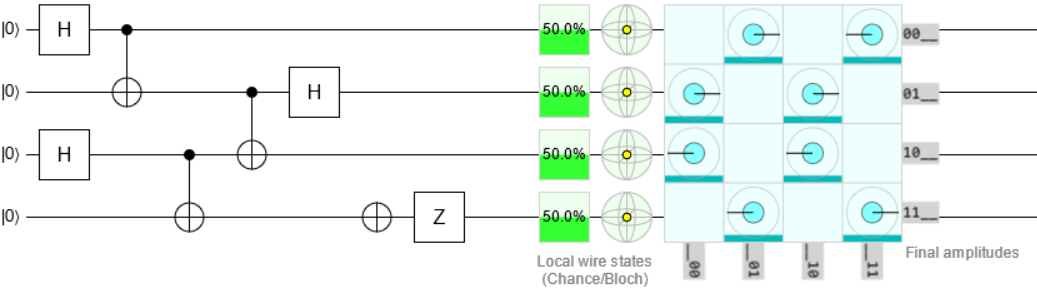

In [6]:
sim_ciruit()

Initial state Alice:
 [[1.+0.j]
 [0.+0.j]]
Initial state Bob:
 [[1.+0.j]
 [0.+0.j]]
Final state Alice:
 [[0.70710678-1.73191211e-16j]
 [0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j]
 [0.70710678-1.73191211e-16j]]
Final state Bob:
 [[0.70710678-1.73191211e-16j]
 [0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j]
 [0.70710678-1.73191211e-16j]]


### 3. Adding the Noise

In [7]:
for error in range(10):
    print(f"------------------PROBA {error/10}---------------------------")
    sim_ciruit(error/10)

------------------PROBA 0.0---------------------------
Initial state Alice:
 [[1.+0.j]
 [0.+0.j]]
Initial state Bob:
 [[1.+0.j]
 [0.+0.j]]
Final state Alice:
 [[ 0.        +0.00000000e+00j]
 [-0.70710678+1.73191211e-16j]
 [ 0.70710678-1.73191211e-16j]
 [ 0.        +0.00000000e+00j]]
Final state Bob:
 [[ 0.        +0.00000000e+00j]
 [-0.70710678+1.73191211e-16j]
 [ 0.70710678-1.73191211e-16j]
 [ 0.        +0.00000000e+00j]]
------------------PROBA 0.1---------------------------
Initial state Alice:
 [[1.+0.j]
 [0.+0.j]]
Initial state Bob:
 [[1.+0.j]
 [0.+0.j]]
Final state Alice:
 [[ 0.        +0.00000000e+00j]
 [-0.70710678+1.73191211e-16j]
 [-0.70710678+1.73191211e-16j]
 [ 0.        +0.00000000e+00j]]
Final state Bob:
 [[ 0.        +0.00000000e+00j]
 [-0.70710678+1.73191211e-16j]
 [-0.70710678+1.73191211e-16j]
 [ 0.        +0.00000000e+00j]]
------------------PROBA 0.2---------------------------
Initial state Alice:
 [[1.+0.j]
 [0.+0.j]]
Initial state Bob:
 [[1.+0.j]
 [0.+0.j]]
Final s

# Exo 2 : GHZ state distribution

### 1. Building the circuit + Testing

In [8]:
alice = Node("Alice")
bob = Node("Bob")
charlie = Node("Charlie")

qmem_A = QuantumMemory("QMA", num_positions=3)
qmem_B = QuantumMemory("QMB", num_positions=3)
qmem_C = QuantumMemory("QMC", num_positions=3)

alice.add_subcomponent(qmem_A, name="qm")
bob.add_subcomponent(qmem_B, name="qm")
charlie.add_subcomponent(qmem_C, name="qm")



#Creation system Charlie -> Alice:
ch_C_to_A = QuantumChannel(name="Charlie_to_Alice")
charlie.add_ports(['qoutC1'])

charlie.qmemory.ports['qout0'].forward_output(charlie.ports['qoutC1'])
ch_C_to_A.ports['send'].connect(charlie.ports['qoutC1'])

alice.add_ports(['qinA'])
alice.ports['qinA'].forward_input(alice.qmemory.ports['qin'])
ch_C_to_A.ports['recv'].connect(alice.ports['qinA'])


#Creation system Charlie -> Bob:
ch_C_to_B = QuantumChannel(name="Charlie_to_Bob")
charlie.add_ports(['qoutC2'])

charlie.qmemory.ports['qout1'].forward_output(charlie.ports['qoutC2'])
ch_C_to_B.ports['send'].connect(charlie.ports['qoutC2'])

bob.add_ports(['qinB'])
bob.ports['qinB'].forward_input(bob.qmemory.ports['qin'])
ch_C_to_B.ports['recv'].connect(bob.ports['qinB'])

In [9]:
def sim_test_GHZ():
    ns.sim_reset()

    Q1 = ns.qubits.create_qubits(3)
    charlie.qmemory.put(Q1)
    
    peek = charlie.qmemory.peek([0, 1, 2])
    print("peekC:", peek)

    #Test system Charlie -> Alice:
    ch_C_to_A.send(qmem_C.pop(0))    #Be careful here the charlie.qmemory.pop(0) is not working
    ch_C_to_A.receive() 

    peek = charlie.qmemory.peek([0, 1, 2])
    print("\npeekC:", peek)
    
    peek = alice.qmemory.peek([0, 1, 2])
    print("peekA:", peek)

    #Test system Charlie -> Bob:
    ch_C_to_B.send(qmem_C.pop(1))
    ch_C_to_B.receive() 

    peek = charlie.qmemory.peek([0, 1, 2])
    print("\npeekC:", peek)
    
    peek = bob.qmemory.peek([0, 1, 2])
    print("peekB:", peek)

In [10]:
sim_test_GHZ()

peekC: [Qubit('QS#13-0'), Qubit('QS#13-1'), Qubit('QS#13-2')]

peekC: [None, Qubit('QS#13-1'), Qubit('QS#13-2')]
peekA: [Qubit('QS#13-0'), None, None]

peekC: [None, None, Qubit('QS#13-2')]
peekB: [Qubit('QS#13-1'), None, None]


### 2. Charlie create a GHZ

In [11]:
def sim_ciruit_GHZ(p = 0):
    ns.sim_reset()
    
    Q = ns.qubits.create_qubits(3)
    
    #Depolarizing error
    if p != 0:
        for q in range(3):
            ns.qubits.qubitapi.depolarize(Q[q], prob=p)
    
    charlie.qmemory.put(Q)
    
    print('Initial state Charlie:', qmem_C.peek([0, 1, 2])[1].qstate.qrepr.ket)

    INSTR_H(qmem_C, positions=[0])
    INSTR_CX(qmem_C, positions=[0, 1])
    INSTR_CX(qmem_C, positions=[0, 2])

    
    ch_C_to_A.send(qmem_C.pop(0))    
    ch_C_to_A.receive() 
    
    ch_C_to_B.send(qmem_C.pop(1))    
    ch_C_to_B.receive()
    
    print('Final state Charlie:', qmem_C.peek([0, 1, 2])[2].qstate.qrepr.ket)

In [12]:
sim_ciruit_GHZ()

Initial state Charlie: [[1.+0.j]
 [0.+0.j]]
Final state Charlie: [[0.70710678+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.70710678+0.j]]


### 3. Adding noise

In [13]:
for error in range(10):
    print(f"------------------PROBA {error/10}---------------------------")
    sim_ciruit_GHZ(error/10)

------------------PROBA 0.0---------------------------
Initial state Charlie: [[1.+0.j]
 [0.+0.j]]
Final state Charlie: [[0.70710678+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.70710678+0.j]]
------------------PROBA 0.1---------------------------
Initial state Charlie: [[1.+0.j]
 [0.+0.j]]
Final state Charlie: [[0.70710678+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.70710678+0.j]]
------------------PROBA 0.2---------------------------
Initial state Charlie: [[1.+0.j]
 [0.+0.j]]
Final state Charlie: [[ 0.70710678+0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [-0.70710678+0.j]]
------------------PROBA 0.3---------------------------
Initial state Charlie: [[1.+0.j]
 [0.+0.j]]
Final state Charlie: [[0.70710678+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0. 

### 4. Scalling the simulation

In [14]:
charlie = Node("Charlie")

nbr_N=10
nbr_qubits_C = nbr_N + 1
NodesN = [Node(f"N{i}") for i in range(nbr_N)]

qmem_C = QuantumMemory("QMC", num_positions=nbr_qubits_C) #here C has n+1 qmem places,to allow 1 qubit to stay in C
qmem_N = [QuantumMemory(f"QMN{i}", num_positions=nbr_N) for i in range(nbr_N)]

charlie.add_subcomponent(qmem_C, name="qm")
for i in range(nbr_N): NodesN[i].add_subcomponent(qmem_N[i], name="qm")


#Creation system Charlie -> N:
ChanelsN = [f"ch_C_to_N{i}" for i in range(nbr_N)]

for i in range(nbr_N):
    ChanelsN[i] = QuantumChannel(name=f"Charlie_to_N{i}")
    charlie.add_ports([f'qoutC{i}'])

    charlie.qmemory.ports[f'qout{i}'].forward_output(charlie.ports[f'qoutC{i}'])
    ChanelsN[i].ports['send'].connect(charlie.ports[f'qoutC{i}'])

    NodesN[i].add_ports([f'qinN{i}'])
    NodesN[i].ports[f'qinN{i}'].forward_input(NodesN[i].qmemory.ports['qin'])
    ChanelsN[i].ports['recv'].connect(NodesN[i].ports[f'qinN{i}'])


In [15]:
def sim_ciruit_GHZ_scale(n_N, n_qubits_C, p = 0):
    ns.sim_reset()
    
    Q = ns.qubits.create_qubits(n_qubits_C)
    
    #Depolarizing error
    if p != 0:
        for q in range(3):
            ns.qubits.qubitapi.depolarize(Q[q], prob=p)
    
    charlie.qmemory.put(Q)
    
    peek = charlie.qmemory.peek([i for i in range(n_N)])
    print("\npeekC:", peek)
    
    print('Initial state Charlie:', qmem_C.peek([i for i in range(n_N)])[1].qstate.qrepr.ket)

    INSTR_H(qmem_C, positions=[0])
    for i in range(1, n_qubits_C):
        print(f"CX n°{i}\n")
        INSTR_CX(qmem_C, positions=[0, i])
        
    for i in range(n_N):
        print(f"noeud n°{i}\n")      
        ChanelsN[i].send(qmem_C.pop(i))    
        ChanelsN[i].receive() 
    
    
    peek = charlie.qmemory.peek([i for i in range(n_qubits_C)])
    print("\npeekC:", peek)
    for i in range(n_N):
        peek = NodesN[i].qmemory.peek([i for i in range(n_N)])
        print(f"peekN{i}:", peek)
    
    print('Final state Charlie:', qmem_C.peek([i for i in range(n_qubits_C)])[n_N].qstate.qrepr.ket)

In [16]:
sim_ciruit_GHZ_scale(nbr_N, nbr_qubits_C)


peekC: [Qubit('QS#25-0'), Qubit('QS#25-1'), Qubit('QS#25-2'), Qubit('QS#25-3'), Qubit('QS#25-4'), Qubit('QS#25-5'), Qubit('QS#25-6'), Qubit('QS#25-7'), Qubit('QS#25-8'), Qubit('QS#25-9')]
Initial state Charlie: [[1.+0.j]
 [0.+0.j]]
CX n°1

CX n°2

CX n°3

CX n°4

CX n°5

CX n°6

CX n°7

CX n°8

CX n°9

CX n°10

noeud n°0

noeud n°1

noeud n°2

noeud n°3

noeud n°4

noeud n°5

noeud n°6

noeud n°7

noeud n°8

noeud n°9


peekC: [None, None, None, None, None, None, None, None, None, None, Qubit('QS#25-10')]
peekN0: [Qubit('QS#25-0'), None, None, None, None, None, None, None, None, None]
peekN1: [Qubit('QS#25-1'), None, None, None, None, None, None, None, None, None]
peekN2: [Qubit('QS#25-2'), None, None, None, None, None, None, None, None, None]
peekN3: [Qubit('QS#25-3'), None, None, None, None, None, None, None, None, None]
peekN4: [Qubit('QS#25-4'), None, None, None, None, None, None, None, None, None]
peekN5: [Qubit('QS#25-5'), None, None, None, None, None, None, None, None, None]
pe